In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import catboost as ctb 
import joblib, gc, os, sys
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import KFold, train_test_split
from itertools import combinations
import warnings
from create_feature import ( reduce_mem_usage )
from time import time 

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [2]:
def load_csv(csv_file):
    df = pd.read_csv(csv_file)
    df = reduce_mem_usage(df)
    df = df[df['target'].notnull()].reset_index(drop=True)
    df = df.drop(columns=['row_id', 'time_id'])
    df['imbalance_buy_sell_flag'] = df['imbalance_buy_sell_flag'].replace({-1: 0, 1: 1})
    return df

def gen_features(df):

    prices =  ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    ## V1 features: row-wise features
    v1_features = {
        "volume": "ask_size + bid_size",
        "mid_price": "(ask_price + bid_price)/2",
        "liquidity_imbalance": "(bid_size-ask_size)/(bid_size+ask_size)",
        "matched_imbalance": "(imbalance_size - matched_size)/(matched_size+imbalance_size)",
        "size_imbalance": "bid_size / ask_size",
        "imbalance_intensity": "imbalance_size / volume",
        "matched_intensity": "matched_size / volume",
        "price_spread": "ask_price - bid_price",
        'market_urgency': 'price_spread * liquidity_imbalance',
        'depth_pressure': '(ask_size - bid_size) * (far_price - near_price)',
        'price_pressure': 'imbalance_size * (ask_price - bid_price)',
        'imbalance_with_flag': 'imbalance_size * imbalance_buy_sell_flag',
        'far_price_near_price_imbalance': '(far_price - near_price) / (far_price + near_price)',
    }

    # include pair-wise price imbalances
    for c in combinations(["reference_price", "ask_price", "bid_price", "wap"], 2):
        v1_features[f"{c[0]}_{c[1]}_imbalance"] = f"({c[0]} - {c[1]}) / ({c[0]} + {c[1]})"

    for k, v in v1_features.items():
        df[k] = df.eval(v)

    # fill nan before calculating rolling stats
    df.fillna(0, inplace=True)

    # time-seires shifts
    roll_window = 5
    gp = df.groupby(['date_id', 'stock_id'])

    row_shifts = [
        gp[prices+sizes].shift(i).add_prefix(f"prev_{i}_") for i in range(1, roll_window+1) 
        ]
    
    df_shifts = pd.concat(row_shifts, axis=1)
    for col in prices+sizes:
        prev_cols = [f"prev_{i}_{col}" for i in range(1, roll_window+1)]
        df_shifts[f"mean_{roll_window}_"+col] = df_shifts[prev_cols].mean(axis=1)
        df_shifts[f"std_{roll_window}_"+col] = df_shifts[prev_cols].std(axis=1)
        df_shifts.drop(columns=prev_cols, inplace=True)

    df_shifts = df_shifts.fillna(0)

    future_wap = gp['wap'].shift(-6).rename('future_wap')
    wap_chg = 1e4 * (future_wap / df['wap'] - 1).rename('wap_chg') 

    df = pd.concat([df, future_wap, wap_chg, df_shifts], axis=1)
    df = df.dropna().reset_index(drop=True)

    # This feature shall be pre-calculated and loaded from an external csv. We don't use it for now.
    # wap_chg_std = df.groupby(['date_id', 'stock_id'])['wap_chg'].std().reset_index().rename(columns={'wap_chg': 'wap_chg_std'})
    # df = df.merge(wap_chg_std, on=['date_id', 'stock_id'], how='left')
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df = reduce_mem_usage(df, verbose=0)

    return df


def split_dataset(df, feature_cols, target_col, n_fold=5):

    dates_list = df['date_id'].unique()
    dates_list.sort()

    datasets = {}
    
    k_fold = KFold(n_splits=n_fold, shuffle=False, random_state=None)
    kf_split = k_fold.split(dates_list)

    for i, (train_idx, valid_idx) in enumerate(kf_split):
        
        half_valid = int(len(valid_idx)/2)
        train_dates = dates_list[train_idx]
        test_dates = dates_list[valid_idx[:half_valid]]
        valid_dates = dates_list[valid_idx[half_valid:]]

        df_train = df[df['date_id'].isin(train_dates)]
        df_test = df[df['date_id'].isin(test_dates)]
        df_valid = df[df['date_id'].isin(valid_dates)]
        print(f"Fold {i}: train {df_train.shape}, valid {df_valid.shape}")
        print(f"Number of Valid Dates: {len(test_dates)}")
        
        datasets[f"fold_{i}"] = {
            'x_train': df_train[feature_cols],
            'y_train': df_train[target_col],
            'x_test': df_test[feature_cols],
            'y_test': df_test[target_col],
            'x_valid': df_valid[feature_cols],
            'y_valid': df_valid[target_col],
        }
        
    return datasets


def train_lgbm(lgb_params, x_train, y_train, x_test, y_test, feature_cols, category_cols):

    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        x_train, 
        y_train,
        eval_set=[(x_test, y_test)],
        feature_name = feature_cols,
        categorical_feature = category_cols,
        callbacks=[lgb.callback.log_evaluation(period=500)]
    )
    
    return lgb_model


def valid_lgbm(lgb_model, x_valid, y_valid, scaler_target):
    y_pred = lgb_model.predict(x_valid)
    
    y_pred = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
    y_valid = scaler_target.inverse_transform(y_valid.values.reshape(-1, 1))

    mae = mean_absolute_error(y_valid, y_pred)
    return mae

In [4]:
save_dir = "/home/lishi/projects/Competition/kaggle_2023/data/target_pred_models"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

train_csv = "/home/lishi/projects/Competition/kaggle_2023/data/train.csv"
df_all = load_csv(train_csv)
df_all = gen_features(df_all)

print("Load Data of Shape: ", df_all.shape)
print("Training days: ", df_all['date_id'].nunique())
print("Stocks: ", df_all['stock_id'].nunique())

feature_cols = [x for x in df_all.columns if x not in ['target', 'date_id', 'future_wap', 'wap_chg']]
category_cols = ['stock_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag' ]

target_col = 'target'

scale_cols = [x for x in feature_cols if x not in category_cols]

Load Data of Shape:  (4666368, 56)
Training days:  481
Stocks:  200


In [5]:
feature_cols

['stock_id',
 'seconds_in_bucket',
 'imbalance_size',
 'imbalance_buy_sell_flag',
 'reference_price',
 'matched_size',
 'far_price',
 'near_price',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap',
 'volume',
 'mid_price',
 'liquidity_imbalance',
 'matched_imbalance',
 'size_imbalance',
 'imbalance_intensity',
 'matched_intensity',
 'price_spread',
 'market_urgency',
 'depth_pressure',
 'price_pressure',
 'imbalance_with_flag',
 'far_price_near_price_imbalance',
 'reference_price_ask_price_imbalance',
 'reference_price_bid_price_imbalance',
 'reference_price_wap_imbalance',
 'ask_price_bid_price_imbalance',
 'ask_price_wap_imbalance',
 'bid_price_wap_imbalance',
 'mean_5_reference_price',
 'std_5_reference_price',
 'mean_5_far_price',
 'std_5_far_price',
 'mean_5_near_price',
 'std_5_near_price',
 'mean_5_ask_price',
 'std_5_ask_price',
 'mean_5_bid_price',
 'std_5_bid_price',
 'mean_5_wap',
 'std_5_wap',
 'mean_5_matched_size',
 'std_5_matched_size',
 'mean_5_bid_size',
 '

In [6]:
df_all[(df_all['date_id'] == 1)&(df_all['stock_id'] == 0)] 

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,imbalance_intensity,matched_intensity,price_spread,market_urgency,depth_pressure,price_pressure,imbalance_with_flag,far_price_near_price_imbalance,reference_price_ask_price_imbalance,reference_price_bid_price_imbalance,reference_price_wap_imbalance,ask_price_bid_price_imbalance,ask_price_wap_imbalance,bid_price_wap_imbalance,future_wap,wap_chg,mean_5_reference_price,std_5_reference_price,mean_5_far_price,std_5_far_price,mean_5_near_price,std_5_near_price,mean_5_ask_price,std_5_ask_price,mean_5_bid_price,std_5_bid_price,mean_5_wap,std_5_wap,mean_5_matched_size,std_5_matched_size,mean_5_bid_size,std_5_bid_size,mean_5_ask_size,std_5_ask_size,mean_5_imbalance_size,std_5_imbalance_size
9359,0,1,0,1.870169e+06,1,0.999923,5132566.5,0.000000,0.000000,0.999601,9302.000000,1.000998,23287.500000,1.000000,-14.089942,32589.500000,1.000299,-0.429141,-0.465875,0.399442,57.385643,157.491409,0.001397,-5.995163e-04,0.000000,2612.652100,1.870169e+06,0.000000,-0.000537,0.000161,-0.000039,0.000698,0.000499,-0.000200,0.998373,-16.270279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
9550,0,1,10,1.112219e+06,1,0.999278,5890517.0,0.000000,0.000000,0.999064,8088.390137,0.999493,23252.500000,0.999175,-3.079772,31340.890625,0.999279,-0.483844,-0.682347,0.347850,35.487793,187.949890,0.000429,-2.075569e-04,0.000000,477.113739,1.112219e+06,0.000000,-0.000108,0.000107,0.000052,0.000215,0.000159,-0.000056,0.998744,-4.313588,0.999923,0.000000,0.000000,0.000000,0.000000,0.000000,1.000998,0.000000,0.999601,0.000000,1.000000,0.000000,5132566.5,0.000000e+00,9302.000000,0.000000,23287.500000,0.000000,1.870169e+06,0.000000
9741,0,1,20,9.378299e+05,1,0.998634,6064906.0,0.000000,0.000000,0.998419,5574.600098,0.998634,52412.519531,0.998439,2.540350,57987.121094,0.998526,-0.807730,-0.732153,0.106360,16.173071,104.590569,0.000215,-1.736570e-04,0.000000,201.627747,9.378299e+05,0.000000,0.000000,0.000108,0.000098,0.000108,0.000098,-0.000010,0.998708,2.694130,0.999601,0.000456,0.000000,0.000000,0.000000,0.000000,1.000246,0.001064,0.999333,0.000380,0.999588,0.000583,5511542.0,5.359519e+05,8695.195312,858.151733,23270.000000,24.748737,1.491194e+06,535951.875000
9932,0,1,30,9.378299e+05,1,0.998204,6064906.0,0.000000,0.000000,0.997989,14673.459961,0.998204,41800.500000,0.998045,2.390146,56473.960938,0.998096,-0.480346,-0.732153,0.351036,16.606413,107.392960,0.000215,-1.032715e-04,0.000000,201.627747,9.378299e+05,0.000000,0.000000,0.000108,0.000080,0.000108,0.000080,-0.000028,0.998344,2.995729,0.999278,0.000645,0.000000,0.000000,0.000000,0.000000,0.999708,0.001197,0.999028,0.000592,0.999205,0.000781,5695996.5,4.956742e+05,7654.996582,1901.118042,32984.171875,16825.451172,1.306739e+06,495674.156250
10123,0,1,40,9.378299e+05,1,0.998634,6064906.0,0.000000,0.000000,0.998419,4738.410156,0.998634,4646.500000,0.998527,-0.540018,9384.910156,0.998526,0.009793,-0.732153,1.019781,99.929550,646.240173,0.000215,2.105521e-06,0.000000,201.627747,9.378299e+05,0.000000,0.000000,0.000108,0.000054,0.000108,0.000054,-0.000054,0.998368,-1.592040,0.999010,0.000752,0.000000,0.000000,0.000000,0.000000,0.999332,0.001233,0.998768,0.000710,0.998915,0.000862,5788223.5,4.447683e+05,9409.613281,3837.213379,35188.253906,14427.834961,1.214512e+06,444768.281250
10314,0,1,50,4.509549e+05,1,0.998634,6551781.0,0.000000,0.000000,0.998526,1022.119995,0.998634,17935.490234,0.998532,0.740290,18957.609375,0.998580,-0.892168,-0.871206,0.056989,23.787540,345.601654,0.000108,-9.635736e-05,0.000000,48.704762,4.509549e+05,0.000000,0.000000,0.000054,0.000051,0.000054,0.000051,-0.000003,0.998726,1.943111,0.998935,0.000673,0.000000,0.000000,0.000000,0.0

In [7]:
lgb_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.009, #0.009,#0.018,
    'max_depth': 20,#9,
    'n_estimators': 100000,#600,
    'num_leaves': 200,#440, # Key parameter! 
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 100,
    'num_threads': 12,
    'importance_type': 'gain',
    'verbose': -1,
    }

# loop over all stocks and train a model for each stock
n_fold = 1
# mae_df = pd.DataFrame(columns=['stock_id']+['mae_fold_'+str(x+1) for x in range(n_fold)])

# for stock_id in df_all['stock_id'].unique():
# print("-"*20)
# print(f"Training model for stock_id {stock_id} ...")
# print("-"*20)
tic = time()

df = df_all.copy()
print("Load Data of Shape: ", df.shape)

scaler_features = StandardScaler()
df[scale_cols] = scaler_features.fit_transform(df[scale_cols])

scaler_target = StandardScaler()
df[target_col] = scaler_target.fit_transform(df[[target_col]])

joblib.dump(scaler_features, f"{save_dir}/scaler_features_all.pkl")
joblib.dump(scaler_target, f"{save_dir}/scaler_target_all.pkl")

# datasets = split_dataset(df, feature_cols, target_col, n_fold=n_fold)
# print(f"Dataset shape for stock_id {stock_id}:", df.shape)
# print(f"Training days: {df['date_id'].nunique()}")

x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df[target_col], test_size=0.2, random_state=42)

print(f"Training data shape: {x_train.shape}, test data shape: {x_test.shape}")

model_name = f"lgbm_all_stocks"

mae_list = []
# for fold, data in datasets.items():
fold = 0
print(f"Training model {model_name} for {fold} ...")

lgb_model = train_lgbm(
    lgb_params, 
    x_train, y_train, #data['x_train'], data['y_train'], 
    x_test, y_test, #data['x_test'], data['y_test'],
    feature_cols, 
    category_cols
    )

mae = valid_lgbm(lgb_model, x_test, y_test, scaler_target)
print(f"MAE for fold {fold}: {mae}")
mae_list.append(mae)

joblib.dump(lgb_model, f"{save_dir}/{model_name}_{fold}.pkl")

# mae_df.loc[len(mae_df)] = [stock_id] + mae_list
print("-"*20)
print(f"MAE: {np.mean(mae_list)}")
# print(f"Current Overall MAE: {mae_df[['mae_fold_'+str(x+1) for x in range(n_fold)]].mean(axis=1).mean()}")
print(f"Time elapsed: {time()-tic:.2f} seconds")
print("-"*20)

# mae_df.to_csv(f"{save_dir}/valid_mae_log.csv", index=False)

Load Data of Shape:  (4666368, 56)
Training data shape: (3733094, 52), test data shape: (933274, 52)
Training model lgbm_all_stocks_0 for 0 ...
[500]	valid_0's l1: 0.662051
[1000]	valid_0's l1: 0.658797
[1500]	valid_0's l1: 0.657115
[2000]	valid_0's l1: 0.655957
[2500]	valid_0's l1: 0.655035
[3000]	valid_0's l1: 0.654237
[3500]	valid_0's l1: 0.653505
[4000]	valid_0's l1: 0.652842
[4500]	valid_0's l1: 0.65224
[5000]	valid_0's l1: 0.651642
[5500]	valid_0's l1: 0.651078
[6000]	valid_0's l1: 0.650614
[6500]	valid_0's l1: 0.650112
[7000]	valid_0's l1: 0.649668
[7500]	valid_0's l1: 0.649221
[8000]	valid_0's l1: 0.648776
[8500]	valid_0's l1: 0.6484
[9000]	valid_0's l1: 0.648034
[9500]	valid_0's l1: 0.647697
[10000]	valid_0's l1: 0.647342
[10500]	valid_0's l1: 0.647031
[11000]	valid_0's l1: 0.646793
[11500]	valid_0's l1: 0.646517
[12000]	valid_0's l1: 0.64624
[12500]	valid_0's l1: 0.645982
[13000]	valid_0's l1: 0.64574
[13500]	valid_0's l1: 0.645517
[14000]	valid_0's l1: 0.645307
[14500]	valid

num_leaves = 200, max_depth=20, mae = 6.06442


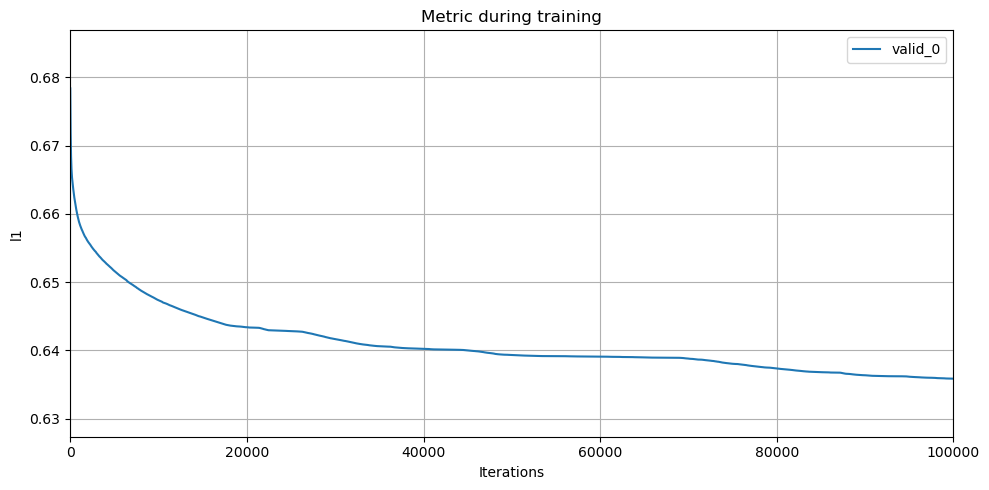

In [9]:
# plot mae list and add value to plot
print(f"num_leaves = {lgb_params['num_leaves']}, max_depth={lgb_params['max_depth']}, mae = {np.mean(mae_list):.5f}")

models = [
    joblib.load(f"{save_dir}/lgbm_all_stocks_0_{i}.pkl") for i in range(n_fold)
]
fig, ax = plt.subplots(1, n_fold, figsize=(10, 5))
# for i, model in enumerate(models):
lgb.plot_metric(models[0], ax=ax)
# axes[i].set_title(f"Fold {i}")

plt.tight_layout()
plt.show()

# axes[-1].plot(mae_list)
# for i, v in enumerate(mae_list):
#     axes[-1].text(i, v, f"{v:.5f}", color='red', fontweight='bold')

# plt.show()

In [20]:
daily_average = df_all.groupby(['stock_id', 'seconds_in_bucket'])['target'].agg(['mean', 'std']).reset_index()

daily_average.columns = ['stock_id', 'seconds_in_bucket', 'average_target', 'std_target']

daily_average

,stock_id,seconds_in_bucket,average_target,std_target
0,0,0,-0.619229,7.768797
1,0,10,-0.061908,5.946762
2,0,20,0.001317,5.813737
3,0,30,0.279527,5.975705
4,0,40,0.167825,5.497067
...,...,...,...,...
9795,199,440,-0.444217,7.292015
9796,199,450,-0.401854,7.497432
9797,199,460,-0.179856,7.247239
9798,199,470,0.008563,6.953167


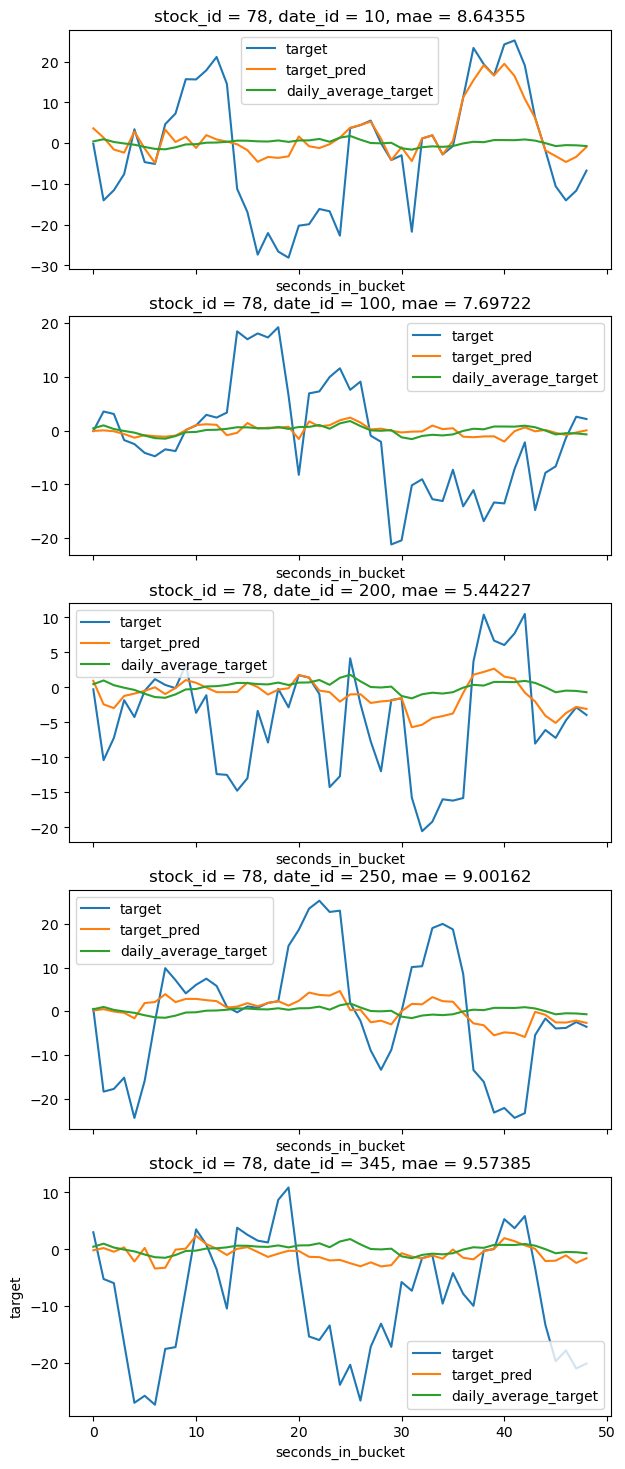

In [41]:
stock_id = 78
date_id = [10, 100, 200, 250, 345]

fig, axes = plt.subplots(5, 1, figsize=(7, 18), sharex=True)

for ax, date_id in zip(axes, date_id):
    
    df = df_all[ (df_all['date_id'] == date_id) & (df_all['stock_id'] == stock_id) ].copy()

    df = df.join(daily_average.set_index(['stock_id', 'seconds_in_bucket']), on=['stock_id', 'seconds_in_bucket'], how='left')

    df[scale_cols] = scaler_features.transform(df[scale_cols])

    target_pred = lgb_model.predict(df[feature_cols])

    target_pred = scaler_target.inverse_transform(target_pred.reshape(-1, 1)).squeeze()

    target_raw = df['target'].values

    mae = mean_absolute_error(target_raw, target_pred)
    # target_adj = target_raw + np.random.normal(0,1,len(target_raw))*df['std_target']

    ax.plot(target_raw, label='target')
    ax.plot(target_pred, label='target_pred')
    ax.plot(df['average_target'].values, label='daily_average_target')
    # ax.plot((target_pred+np.random.normal(0,1,len(target_pred))*df['std_target']).values)
    ax.set_title(f"stock_id = {stock_id}, date_id = {date_id}, mae = {mae:.5f}")
    ax.set_xlabel('seconds_in_bucket')
    ax.legend()

ax.set_ylabel('target')

plt.show()

In [25]:
df['average_target']+target_pred*df['std_target']

4636980   -1.913612
4637180    0.635139
4637380    0.797061
4637580    0.981997
4637780    1.198131
4637980    0.982174
4638180    1.267684
4638380    0.394642
4638580    0.241562
4638780   -0.843993
4638980   -1.254742
4639180   -1.037728
4639380   -1.022337
4639580   -0.555971
4639780   -0.137111
4639980    0.833374
4640180    0.362576
4640380    0.339129
4640580   -0.000474
4640780    0.692814
4640980   -0.120249
4641180   -0.534653
4641380    0.374733
4641580   -0.665699
4641780    0.433090
4641980    0.334176
4642180   -0.683333
4642380   -0.895063
4642580   -1.586678
4642780   -0.194325
4642980   -1.235159
4643180    0.464582
4643380    0.030617
4643580   -0.040785
4643780    0.416690
4643980    0.203864
4644180   -0.213501
4644380   -0.153250
4644580   -0.513862
4644780   -0.519127
4644980   -0.628673
4645180   -0.961323
4645380   -0.947459
4645580   -0.303234
4645780   -0.810051
4645980   -1.143014
4646180    0.058649
4646380    0.391602
4646580    0.406226
dtype: float64

In [ ]:
# train_parquet = "/home/lishi/projects/Competition/kaggle_2023/data/train_add_daily_features.parquet"
train_csv = "/home/lishi/projects/Competition/kaggle_2023/data/train.csv"

prices =  ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
ta_indicators = ['ema', 'rsi', 'cci', 'mfi', 'ad_osc', 'macd', 'macdhist', 'macdsignal']

stock_labels = [0, 1, 2]

# df_all = pd.read_parquet(train_parquet)
df = pd.read_csv(train_csv)

df = df[~df['target'].isnull()].reset_index(drop=True)
# df_all = df_all.drop(columns=['row_id', 'time_id'])
# df_all['imbalance_buy_sell_flag'] = df_all['imbalance_buy_sell_flag'].replace({-1: 0, 1: 1})

# ## V1 features: row-wise features
# v1_features = {
#     "volume": "ask_size + bid_size",
#     "mid_price": "(ask_price + bid_price)/2",
#     "liquidity_imbalance": "(bid_size-ask_size)/(bid_size+ask_size)",
#     "matched_imbalance": "(imbalance_size - matched_size)/(matched_size+imbalance_size)",
#     "size_imbalance": "bid_size / ask_size",
#     "imbalance_intensity": "imbalance_size / volume",
#     "matched_intensity": "matched_size / volume",
#     "price_spread": "ask_price - bid_price",
#     'market_urgency': 'price_spread * liquidity_imbalance',
#     'depth_pressure': '(ask_size - bid_size) * (far_price - near_price)',
#     'price_pressure': 'imbalance_size * (ask_price - bid_price)',
#     'imbalance_with_flag': 'imbalance_size * imbalance_buy_sell_flag',
#     'far_price_near_price_imbalance': '(far_price - near_price) / (far_price + near_price)',
# }

# # include pair-wise price imbalances
# for c in combinations(["reference_price", "ask_price", "bid_price", "wap"], 2):
#     v1_features[f"{c[0]}_{c[1]}_imbalance"] = f"({c[0]} - {c[1]}) / ({c[0]} + {c[1]})"

# for k, v in v1_features.items():
#     df_all[k] = df_all.eval(v)

# v1_features = list(v1_features.keys())

# time-seires shifts
# gp = df_all.groupby(['date_id', 'stock_id'])
# roll_window = 5
# row_shifts = [
#     gp[prices+sizes].shift(i).add_prefix(f"prev_{i}_") for i in range(1, roll_window+1) 
#     ]
# df_shift = pd.concat(row_shifts, axis=1)
# df_shift = df_shift.fillna(0)
# df_all = pd.concat([df_all, df_shift], axis=1)

# time-seires shifts



# print(df_all.shape)

# df_all.fillna(0, inplace=True)
# df_all.replace([np.inf, -np.inf], 0, inplace=True)
# df_all = reduce_mem_usage(df_all, verbose=0)

# df_all.head()

In [ ]:
roll_window = 5
gp = df.groupby(['date_id', 'stock_id'])

row_shifts = [
    gp[prices+sizes].shift(i).add_prefix(f"prev_{i}_") for i in range(1, roll_window+1) 
    ]

future_wap = gp['wap'].shift(-6).rename('future_wap')
wap_chg = 1e4 * (future_wap / df['wap'] - 1).rename('wap_chg') 
df = pd.concat([df, future_wap, wap_chg]+row_shifts, axis=1)
# df['wap_chg'] = df['future_wap'] / df['wap'] - 1

df


In [ ]:
df[(df['date_id'] == 0) & (df['stock_id'] == 0)]

In [ ]:
stock_choice = 112

df = df_all[df_all['stock_id'] == stock_choice].reset_index(drop=True)
print(df.shape)
print(np.sum(df.isnull().values))

category_cols = ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag']
feature_cols = [
    x for x in df_all.columns if x not in ['target', 'date_id', 'row_id'] #+ ta_indicators
    ]

print("Number of features",len(feature_cols))

dates_list = df['date_id'].unique()

k_fold = KFold(n_splits=5, shuffle=False, random_state=None)
kf_split = list(k_fold.split(dates_list))

wap_shift = df.groupby('date_id')['wap'].shift(-6)
wap_shift.name = 'wap_shift'
wap_shift = wap_shift.dropna()

df = df.join(wap_shift, how='inner')

df['wap_chg'] = (df['wap_shift'] / df['wap'] - 1) * 1e4

daily_std_chg = df.groupby('date_id')['wap_chg'].std().shift(1)
daily_std_chg.name = 'std_chg_1d'
daily_std_chg = daily_std_chg.dropna()
daily_std_chg = daily_std_chg.reset_index()

df = df.merge(daily_std_chg, on=['date_id'], how='left')
df = df.fillna(0)

std_chg_on_sec = df.groupby('seconds_in_bucket')['wap_chg'].std()
std_chg_on_sec.name = 'std_chg_on_sec'
std_chg_on_sec = std_chg_on_sec.reset_index()
df = df.merge(std_chg_on_sec, on=['seconds_in_bucket'], how='left')

print(df.shape)
feature_cols += ['std_chg_1d', 'std_chg_on_sec']
# feature_cols = feature_cols[:100]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df[feature_cols], test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

In [ ]:
# df.groupby('seconds_in_bucket')['wap_chg'].std().reset_index()



In [ ]:
df_raw = df[['date_id', 'seconds_in_bucket', 'wap', 'wap_shift', 'wap_chg']].copy()

scale_cols = [x for x in feature_cols if x not in category_cols]

scaler_features = StandardScaler()
df[scale_cols] = scaler_features.fit_transform(df[scale_cols])

scaler_wap_chg = StandardScaler()
df['wap_chg'] = scaler_wap_chg.fit_transform(df[['wap_chg']])

In [ ]:
lgb_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.012, #0.009,#0.018,
    'max_depth': 64,#9,
    'n_estimators': 500,#600,
    'num_leaves': 600,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 16,
    'importance_type': 'gain',
    'verbose': -1,
    }


# cat_params = dict(
#     iterations=1200,
#     learning_rate=1.0,
#     depth=8,
#     l2_leaf_reg=30,
#     bootstrap_type='Bernoulli',
#     subsample=0.66,
#     loss_function='MAE',
#     eval_metric = 'MAE',
#     metric_period=100,
#     od_type='Iter',
#     od_wait=30,
#     thread_count=16,
#     allow_writing_files=False,
#     )

In [ ]:
mae_list = []
lgb_models = []
cat_models = []

for fold, (train_idx, valid_idx) in enumerate(kf_split):
    
    print(f"Fold {fold+1}")

    train_dates = dates_list[train_idx]
    
    half_valid = int(len(valid_idx)/2)
    valid_dates_1 = dates_list[valid_idx[:half_valid]]
    valid_dates_2 = dates_list[valid_idx[half_valid:]]
    
    print(f"Valid Dates 1: {valid_dates_1[0]} - {valid_dates_1[-1]}")
    print(f"Valid Dates 2: {valid_dates_2[0]} - {valid_dates_2[-1]}")
    
    # split train and valid set
    df_train_fold = df[df["date_id"].isin(train_dates)].reset_index(drop=True)
    df_valid_fold_1 = df[df["date_id"].isin(valid_dates_1)].reset_index(drop=True)
    df_valid_fold_2 = df[df["date_id"].isin(valid_dates_2)].reset_index(drop=True)

    print("Start training LightGBM...")
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        df_train_fold[feature_cols].values, 
        df_train_fold['wap_chg'].values,
        eval_set=[(
            df_valid_fold_1[feature_cols].values, 
            df_valid_fold_1['wap_chg'].values
            )],
        feature_name = feature_cols,
        categorical_feature = category_cols,
        callbacks=[lgb.callback.log_evaluation(period=100)],
        )
    
    valid_pred_lgb = lgb_model.predict(df_valid_fold_2[feature_cols].values)

    df_valid_fold_2['pred_wap_chg'] = scaler_wap_chg.inverse_transform(valid_pred_lgb.reshape(-1, 1))

    df_raw_pred = df_raw.merge(
        df_valid_fold_2[['date_id', 'seconds_in_bucket', 'pred_wap_chg']], 
        on=['date_id', 'seconds_in_bucket'], 
        how='inner')
    
    df_raw_pred['pred_wap'] = df_raw_pred['pred_wap_chg'] * df_raw_pred['wap'] / 1e4 + df_raw_pred['wap']
    
    valid_mae_lgb = mean_absolute_error(df_raw_pred['wap_shift'], df_raw_pred['pred_wap']) * 1e4
    mae_list.append(valid_mae_lgb)
    print(f"Valid MAE: {valid_mae_lgb}")

    lgb_models.append(lgb_model)
    df_raw_pred = pd.DataFrame()


    # print("Start training Catboost...")
    # cat_model = ctb.CatBoostRegressor(**cat_params)
    # cat_model.fit( 
    #     df_train_fold[feature_cols], 
    #     df_train_fold['wap_chg'], 
    #     eval_set=( 
    #         df_valid_fold_1[feature_cols], 
    #         df_valid_fold_1['wap_chg']
    #         ),
    #     cat_features=category_cols,
    #     verbose=100 )
    
    # valid_pred_cat = cat_model.predict(df_valid_fold_2[feature_cols])

    # df_valid_fold_2['pred_wap_chg'] = scaler_wap_chg.inverse_transform(valid_pred_cat.reshape(-1, 1))
    # df_raw_pred = df_raw.merge(
    #     df_valid_fold_2[['date_id', 'seconds_in_bucket', 'pred_wap_chg']], 
    #     on=['date_id', 'seconds_in_bucket'], 
    #     how='inner')
    
    # df_raw_pred['pred_wap'] = df_raw_pred['pred_wap_chg'] * df_raw_pred['wap'] / 1e4 + df_raw_pred['wap']
    # valid_mae_cat = mean_absolute_error(df_raw_pred['wap_shift'], df_raw_pred['pred_wap']) * 1e4

    # mae_list.append(valid_mae_cat)
    # print(f"Valid MAE: {valid_mae_cat}")
    # cat_models.append(cat_model)

    # df_raw_pred = pd.DataFrame()


# print(f"Average MAE: {np.mean(mae_list)}")
# lgb_model_collection[choose_stock] = dict(models=lgb_models, scaler=scaler, mae=mae_list)

In [ ]:
print(np.mean(mae_list))


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(12, 20))

date_list = [90, 271, 410, 83, 279] #np.random.choice(df['date_id'].unique(), axes.size, replace=False)

for ax, date_choice in zip(axes, date_list):

    df_date = df[df['date_id'] == date_choice].reset_index(drop=True)

    pred_wap_chg = [
        _model.predict(df_date[feature_cols]) for _model in lgb_models
        ]

    pred_wap_chg = [
        scaler_wap_chg.inverse_transform(pred.reshape(-1, 1)).reshape(-1) for pred in pred_wap_chg
        ]

    pred_wap_chg = np.array(pred_wap_chg).mean(axis=0)

    df_date['pred_wap_chg'] = scaler_wap_chg.inverse_transform(pred_wap_chg.reshape(-1, 1))

    df_date_raw = df_raw.merge(
        df_date[['date_id', 'seconds_in_bucket', 'pred_wap_chg']], 
        on=['date_id', 'seconds_in_bucket'], 
        how='inner'
    )

    df_date_raw['pred_wap'] = df_date_raw['pred_wap_chg'] * df_date_raw['wap'] / 1e4 + df_date_raw['wap']

    text_list = [
        f"Date: {date_choice}",
        f"MAE: {mean_absolute_error(df_date_raw['wap_shift'], df_date_raw['pred_wap'])*1e4:.4f}",
        f"Bechmark: {mean_absolute_error(df_date_raw['wap_shift'], df_date_raw['wap'])*1e4:.4f}"
        ]
    
    ax.set_title("|".join(text_list))
    ax.plot(df_date_raw['wap'], label='WAP')
    ax.plot(df_date_raw['wap_shift'], label='True')
    ax.plot(df_date_raw['pred_wap'], label='Pred', ls='dashed')
    # plt.plot(df_date_raw['pred_wap_adj'], label='Pred Adj', ls='dashed')
    ax.legend()
plt.show()

In [ ]:
autocorr_list = []
for lag in range(1, 7):
    autocorr = df.groupby('date_id')['wap'].apply(lambda x: x.autocorr(lag=lag))
    autocorr_list.append(autocorr)

autocorr_df = pd.concat(autocorr_list, axis=1)
autocorr_df.columns = [f'autocorr_wap_{x}' for x in range(1, 7)]
autocorr_df 

In [ ]:
autocorr_df.mean(axis=0)

In [ ]:
feature_cols